# Preprocessing + NN Playing for Beer Reviews

In [1]:
pip install liac-arff

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arff

## Load Dataset and create Dataframe

In [4]:
data = arff.load(open('../data/beer_reviews.arff', 'r'))
attr = np.array(data['attributes'])
numericals = [i[0] for i in attr if i[1] == 'INTEGER' or i[1] == 'REAL']
df = pd.DataFrame(data['data'], columns=attr[:, 0])
df.columns

Index(['brewery_id', 'brewery_name', 'review_time', 'review_overall',
       'review_aroma', 'review_appearance', 'review_profilename', 'beer_style',
       'review_palate', 'review_taste', 'beer_name', 'beer_abv',
       'beer_beerid'],
      dtype='object')

Use only 10% of the data

In [5]:
from sklearn.model_selection import train_test_split
_, df = train_test_split(df, test_size=0.1, random_state=42)

In [6]:
len(df)

158662

In [7]:
df.columns

df['review_time'] = df['review_time'].apply(lambda sec: pd.Timestamp(sec, unit='s'))
display(df.head())

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
859964,13307,Mikkeller ApS,2011-10-03 01:48:53,4.0,4.5,4.5,Ghenna,American Barleywine,3.5,3.5,Big Worst,18.5,56831
581443,126,Pete's Brewing Company,2007-11-17 06:34:54,2.5,3.0,3.5,hwwty4,Cream Ale,3.0,2.5,Pete's Wicked Wanderlust Cream Ale,5.6,19950
1270456,203,Greene King / Morland Brewery,2008-10-15 22:32:23,4.0,3.5,4.0,dsa7783,English Pale Ale,3.5,3.5,Abbot Ale,5.0,910
477415,167,Brewery Lobkowicz,2003-12-03 22:07:06,4.5,4.0,3.5,TastyTaste,Czech Pilsener,4.0,4.5,Lobkowicz Knight,4.8,444
1408999,664,Wells & Young's Ltd,2007-02-23 05:32:26,5.0,4.0,5.0,BadRockBeer,Milk / Sweet Stout,5.0,5.0,Young's Double Chocolate Stout,5.2,73


## Fix Missing Values

The rows with missing brewery name for id 1193 are found through a quick google search and added. For the ones with brewery id 27 where the beers already exist with the correct brewery, so I add it based on the dataset. For the others I google with the provided data.

The missing review profilenames are set to anonynoums, but otherwise kept, because the review is still done correctly.

In [8]:
display(df[df.isna().any(axis=1)])
display(df[df['brewery_name'].isna()])

display(df[df['brewery_id'] == 1193])
df.loc[df['brewery_id'] == 1193, 'brewery_name'] = 'Crailsheimer Engel-Bräu'
df.loc[df['brewery_id'] == 1193, 'beer_name'] = df.loc[df['brewery_id'] == 1193, 'beer_name'].apply(lambda name: name.split(' WRONG')[0])
display(df[df['brewery_id'] == 1193])

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
990101,4338,C.B. & Potts Restaurant & Brewery,2008-03-21 22:47:02,2.5,3.0,3.0,rowew,American Amber / Red Ale,3.0,3.0,Big Horn Buttface Amber Ale,NaN,25912
1274155,1874,Pizzeria Uno Chicago Grill & Brewery,2003-09-02 18:40:29,3.5,3.0,3.0,Dogbrick,Hefeweizen,3.0,2.5,Hefeweizen,NaN,12429
545596,2854,Flensburger Brauerei GmbH Und Co. KG,2007-02-04 03:28:46,4.0,4.5,4.0,Cadyfatcat,Hefeweizen,3.5,3.5,Flensburger Weizen,NaN,6712
723440,341,Columbus Brewing Company,2006-05-12 22:32:21,4.0,3.5,4.0,Ahhdball,American Pale Ale (APA),3.5,3.5,Columbus Pale Ale,NaN,3700
277262,1916,Kettle House Brewing Co.,2002-08-20 17:32:23,4.5,4.0,4.0,beernut7,American Pale Ale (APA),4.0,4.5,Ginseng Pale Ale,NaN,5589
...,...,...,...,...,...,...,...,...,...,...,...,...,...
810185,684,Fish Brewing Company / Fishbowl Brewpub,2009-11-18 05:02:55,3.0,3.0,3.5,RedDiamond,German Pilsener,2.5,3.0,Reister Pilsner,NaN,54202
1495915,1111,Martha's Vineyard Ales,2003-01-13 20:47:10,4.5,4.5,4.5,TheLongBeachBum,Foreign / Export Stout,5.0,5.0,Martha's Vineyard Extra Stout,NaN,3266
1429549,5408,Herkimer Pub & Brewery,2008-11-24 22:56:31,3.5,3.0,4.0,tempest,Altbier,3.5,3.5,Alt,NaN,21231
188478,7776,Brauerei Westheim GmbH,2005-05-24 01:48:32,3.0,3.0,3.5,allengarvin,Märzen / Oktoberfest,3.5,3.5,Westheimer Oktoberfest,NaN,20547


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
659305,1193,None,2010-11-09 19:12:42,3.5,3.5,4.0,dqrull,Keller Bier / Zwickel Bier,4.0,4.0,Engel Keller Dunkel WRONG BREWERY SEE CRAILSH...,5.3,63324
1391053,27,None,2011-11-11 07:10:08,5.0,4.5,4.0,Docer,American Stout,4.5,4.5,Caboose Oatmeal Stout,7.0,75137


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
659305,1193,None,2010-11-09 19:12:42,3.5,3.5,4.0,dqrull,Keller Bier / Zwickel Bier,4.0,4.0,Engel Keller Dunkel WRONG BREWERY SEE CRAILSH...,5.3,63324


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
659305,1193,Crailsheimer Engel-Bräu,2010-11-09 19:12:42,3.5,3.5,4.0,dqrull,Keller Bier / Zwickel Bier,4.0,4.0,Engel Keller Dunkel,5.3,63324


In [9]:
display(df[df['brewery_id'] == 27])

if (1391053 in df.index):
    df.loc[1391053, 'brewery_id'] = 24831
    df.loc[1391053, 'brewery_name'] = 'American Brewing Company'

if (1391051 in df.index):
    df.loc[1391051, 'brewery_id'] = 24831
    df.loc[1391051, 'brewery_name'] = 'American Brewing Company'

if (1391052 in df.index):  
    df.loc[1391052, 'brewery_id'] = 24831
    df.loc[1391052, 'brewery_name'] = 'American Brewing Company'

if (1391049 in df.index):  
    df.loc[1391049, 'brewery_id'] = 782
    df.loc[1391049, 'brewery_name'] = 'City Brewing Company, LLC'
    df.loc[1391049, 'beer_name'] = 'Side Pocket High Gravity Ale'

if (1391050 in df.index):  
    df.loc[1391050, 'brewery_id'] = 782
    df.loc[1391050, 'brewery_name'] = 'City Brewing Company, LLC'
    df.loc[1391050, 'beer_name'] = 'Side Pocket High Gravity Ale'

if (1391050 in df.index):  
    df.drop(1391050, inplace=True)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
1391053,27,None,2011-11-11 07:10:08,5.0,4.5,4.0,Docer,American Stout,4.5,4.5,Caboose Oatmeal Stout,7.0,75137


In [10]:
df.loc[df['review_profilename'].isna(), 'review_profilename'] = 'Anonymous'

In [11]:
len(df['beer_style'].unique())

104

In [12]:
display(len(df.loc[df['beer_abv'].isna(), 'beer_name'].unique()))

def create_mean(df):
    means = {}
    for style in df['beer_style'].unique():
        mean_abv = df.loc[df['beer_style'] == style, 'beer_abv'].mean()
        means[style] = round(mean_abv, 1)

    return means

def fill_mean(means, row):
    return 

means = create_mean(df)
print(means)
df.loc[df['beer_abv'].isna(), 'beer_abv'] = df.loc[df['beer_abv'].isna()].apply(lambda row: means[row['beer_style']], axis=1)

3850

{'American Barleywine': 10.7, 'Cream Ale': 5.2, 'English Pale Ale': 5.0, 'Czech Pilsener': 5.0, 'Milk / Sweet Stout': 5.8, 'Quadrupel (Quad)': 10.5, 'Fruit / Vegetable Beer': 5.8, 'Munich Dunkel Lager': 5.1, 'Pumpkin Ale': 6.5, 'California Common / Steam Beer': 5.3, 'American Pale Wheat Ale': 5.2, 'German Pilsener': 5.1, 'American Amber / Red Ale': 6.0, 'Winter Warmer': 6.6, 'Scotch Ale / Wee Heavy': 8.2, 'Belgian Pale Ale': 6.1, 'English Barleywine': 10.9, 'American IPA': 6.6, 'Belgian Strong Dark Ale': 9.4, 'Smoked Beer': 7.1, 'Belgian Dark Ale': 6.3, 'Irish Dry Stout': 4.9, 'Hefeweizen': 5.3, 'American Amber / Red Lager': 4.9, 'Weizenbock': 8.1, 'American Strong Ale': 9.7, 'American Double / Imperial Stout': 10.6, 'Russian Imperial Stout': 10.0, 'Lambic - Fruit': 5.0, 'Altbier': 5.8, 'American Double / Imperial IPA': 9.4, 'Keller Bier / Zwickel Bier': 5.2, 'American Brown Ale': 6.5, 'Dubbel': 7.6, 'Tripel': 8.9, 'Witbier': 5.5, 'English India Pale Ale (IPA)': 6.1, 'American Adjunct 

In [13]:
print(df[df.isna().any(axis=1)].count())

brewery_id            0
brewery_name          0
review_time           0
review_overall        0
review_aroma          0
review_appearance     0
review_profilename    0
beer_style            0
review_palate         0
review_taste          0
beer_name             0
beer_abv              0
beer_beerid           0
dtype: int64


## Bag of Word for Brewery and Beer Name

In [14]:
from string import punctuation
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import sklearn
sklearn.set_config(transform_output="pandas")

In [15]:
PUNCT_TO_REMOVE = punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [16]:
df["brewery_name"] = df["brewery_name"].str.lower()
df["brewery_name"] = df["brewery_name"].apply(lambda text: remove_punctuation(text))

df["beer_name"] = df["beer_name"].str.lower()
df["beer_name"] = df["beer_name"].apply(lambda text: remove_punctuation(text))

df["text"] = df["brewery_name"] + " " + df["beer_name"]
df['text']

859964                               mikkeller aps big worst
581443     petes brewing company petes wicked wanderlust ...
1270456               greene king  morland brewery abbot ale
477415                    brewery lobkowicz lobkowicz knight
1408999      wells  youngs ltd youngs double chocolate stout
                                 ...                        
1540908                     victory brewing company festbier
912301     bierbrouwerij sint christoffel bv christoffel ...
1192883                  dogfish head brewery 120 minute ipa
209014         new belgium brewing lips of faith  le terroir
212102     gasthausbrauerei braustelle freigeist deutsche...
Name: text, Length: 158662, dtype: object

In [17]:
cnt = Counter()
for text in df["text"].values:
    for word in text.split():
        cnt[word] += 1
        
FREQWORDS = set([w for (w, wc) in cnt.most_common(20)])

counts = list(cnt.values())
print(len(counts))
print(FREQWORDS)

16221
{'lager', 'old', 'company', 'samuel', 'co', 'porter', 'ipa', 'beer', 'de', 'sierra', 'brewery', 'imperial', 'brouwerij', 'stout', 'adams', 'pale', 'brewing', 'ale', 'the', 'stone'}


In [18]:
n_rare = sum([i <= 100 for i in counts])
print(n_rare)
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare-1:-1]])

def remove_rarewords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["text"] = df["text"].apply(lambda text: remove_rarewords(text))

15034


In [19]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])
words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
words.set_index(df.index, inplace=True)
words

,10,100,10th,12,120,13,15,1554,15th,16,...,yakima,yards,yeti,youngs,yuengling,yulesmith,zywiec,éphémère,ølfabrikken,über
859964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1270456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
477415,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1408999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
912301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1192883,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
209014,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_bag = df.merge(words, how='left', left_index=True, right_index=True)

In [21]:
words.index.equals(df.index)

True

## Splitting Training and Test Set

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [23]:
le = LabelEncoder()
le.fit(df['beer_style'])
df['class'] = le.transform(df['beer_style'])

In [24]:
# le = LabelEncoder()
# le.fit(df['review_profilename'])
# df['review_profilecode'] = le.transform(df['review_profilename'])

In [25]:
X = df.copy()
X.drop('brewery_name', axis=1, inplace=True)
X.drop('brewery_id', axis=1, inplace=True)
X.drop('beer_name', axis=1, inplace=True)
X.drop('beer_beerid', axis=1, inplace=True)
X.drop('beer_style', axis=1, inplace=True)
X.drop('review_profilename', axis=1, inplace=True)
X.drop('review_time', axis=1, inplace=True)
X.drop('text', axis=1, inplace=True)

y = df['class']
X.drop('class', axis=1, inplace=True)
# X = normalize(X, norm='l2')
X

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv
859964,4.0,4.5,4.5,3.5,3.5,18.5
581443,2.5,3.0,3.5,3.0,2.5,5.6
1270456,4.0,3.5,4.0,3.5,3.5,5.0
477415,4.5,4.0,3.5,4.0,4.5,4.8
1408999,5.0,4.0,5.0,5.0,5.0,5.2
...,...,...,...,...,...,...
1540908,4.5,3.5,3.0,4.0,4.0,5.6
912301,4.0,2.5,3.5,3.5,3.5,6.4
1192883,2.5,3.5,4.5,3.5,3.5,18.0
209014,4.0,4.5,4.0,4.0,4.5,7.5


In [26]:
X.index.equals(words.index)

True

In [27]:
X_train, X_valid, words_train, words_valid, y_train, y_valid = train_test_split(X, words, y, test_size=0.33, random_state=42)
# words_train, words_test, y_train, y_test = train_test_split(words, y, test_size=0.33, random_state=42)


In [28]:
print(len(X_train))
print(len(words_train))
print(len(y_train))
print(X_train.index.equals(y_train.index))
print(X_train.index.equals(words_train.index))
print(y.max())

106303
106303
106303
True
True
103


## Scaling, Feature Selection, Outlier

## Check for Outliers

array([[<Axes: title={'center': 'review_overall'}>,
        <Axes: title={'center': 'review_aroma'}>],
       [<Axes: title={'center': 'review_appearance'}>,
        <Axes: title={'center': 'review_palate'}>],
       [<Axes: title={'center': 'review_taste'}>,
        <Axes: title={'center': 'beer_abv'}>]], dtype=object)

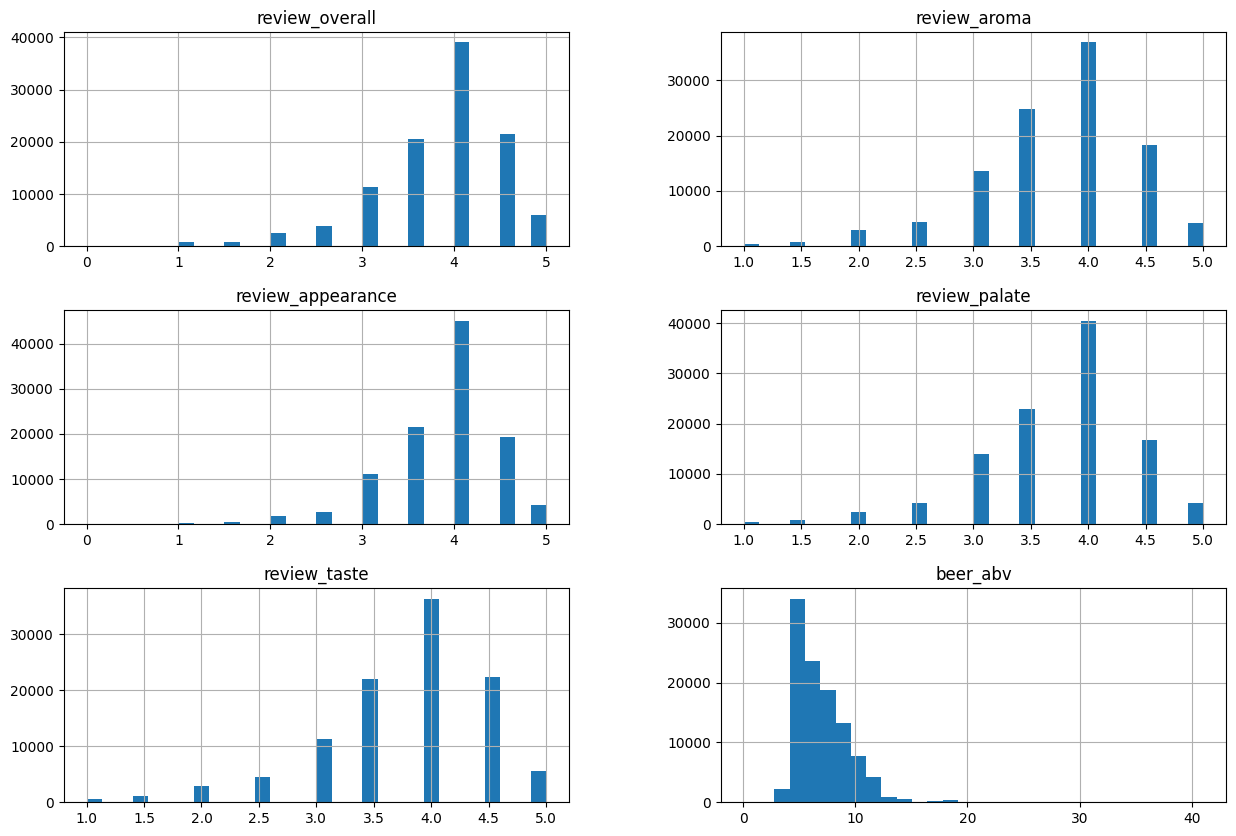

In [29]:
X_train.hist(bins=30, figsize=(15, 10))

In [30]:
len(X_train[X_train['beer_abv'] > 31])
len(X_train[X_train['beer_abv'] > 50])
X_train[X_train['beer_abv'] > 50]

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv


Looks like there exist really that strong beers.

## Feature Selection

In [31]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [32]:
clf = RandomForestClassifier(n_estimators=20, max_features=100).fit(words_train, y_train)
model = SelectFromModel(clf, prefit=True)
words_new = model.transform(words_train)
words_new

KeyboardInterrupt: 

In [35]:
words_new = words_train[words_train.columns[:100]]

In [36]:
words_train.index.equals(X_train.index)

True

In [37]:
f_i = list(zip(clf.feature_names_in_,clf.feature_importances_))
f_i.sort(key = lambda x : x[1])
f_i = f_i[:20]
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

NameError: name 'clf' is not defined

In [38]:
X_train_bag = X_train.merge(words_new, how='inner', left_index=True, right_index=True)

In [39]:
X_train_bag

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,10,100,10th,12,...,autumn,aventinus,avery,aying,ayinger,back,bad,ballast,baltic,baltika
461298,3.5,4.0,3.5,3.5,3.5,3.9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1567650,4.0,3.5,3.0,4.0,4.0,7.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1075743,4.0,3.5,3.5,3.5,3.5,6.6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
771813,4.5,4.0,4.0,4.0,4.5,6.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
319046,3.0,3.5,2.5,2.5,2.5,5.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551606,4.5,2.5,4.5,3.5,4.0,5.4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1210112,3.5,4.0,4.5,4.0,3.5,7.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
829163,4.0,4.0,3.5,3.0,4.5,9.3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1170468,4.0,4.5,3.5,4.0,4.5,6.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
X_valid_bag = X_valid.merge(words_valid[words_new.columns], how='inner', left_index=True, right_index=True)
X_valid_bag

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,10,100,10th,12,...,autumn,aventinus,avery,aying,ayinger,back,bad,ballast,baltic,baltika
1519525,4.0,4.0,4.0,4.0,4.0,5.2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
662262,4.0,4.0,4.5,4.0,4.0,7.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
961338,4.0,4.0,4.5,4.5,4.5,9.8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
728521,4.0,4.0,3.0,3.0,4.0,6.4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1050775,3.0,2.5,3.0,3.0,3.5,4.2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563841,4.5,4.0,4.5,4.0,4.5,4.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884138,4.0,4.5,4.0,4.0,4.0,5.9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550271,3.0,3.0,3.5,3.0,3.5,4.2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
895352,4.0,4.0,4.5,4.0,4.0,8.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Find Solution of NN + THEORIE!

In [41]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [42]:
X_ttrain, X_test, y_ttrain, y_test = train_test_split(X_train_bag.values, y_train.values, test_size=0.3, random_state=42)

In [43]:
print(X_ttrain)
print(y_ttrain)
print(y_ttrain.max())

[[2.5 2.5 4.  ... 0.  0.  0. ]
 [3.  3.  3.5 ... 0.  0.  0. ]
 [4.  3.5 3.  ... 0.  0.  0. ]
 ...
 [3.  3.  3.  ... 0.  0.  0. ]
 [4.  4.  4.5 ... 0.  0.  0. ]
 [2.5 2.  2.  ... 0.  0.  0. ]]
[49 90 73 ... 93 89  1]
103


## Build torch dataset

In [44]:
assert not np.any(np.isnan(X_ttrain))
assert not np.any(np.isnan(y_ttrain))
assert not np.any(np.isnan(X_test))
assert not np.any(np.isnan(y_test))

In [45]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# convert a df to tensor to be used in pytorch
def X_to_tensor(df):
    return torch.from_numpy(df).float().to(device)

def y_to_tensor(df):
    return torch.from_numpy(df).long().to(device)

X_train_tensor = X_to_tensor(X_ttrain)
y_train_tensor = y_to_tensor(y_ttrain)

X_test_tensor = X_to_tensor(X_test)
y_test_tensor = y_to_tensor(y_test)

X_valid_tensor = X_to_tensor(X_valid_bag.values)
y_valid_tensor = y_to_tensor(y_valid.values)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
valid_ds = TensorDataset(X_valid_tensor, y_valid_tensor)

Using cpu device


In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_ds, batch_size=batch_size)
test_dataloader = DataLoader(test_ds, batch_size=batch_size)
valid_dataloader = DataLoader(valid_ds, batch_size=batch_size)

for XX, yy in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {XX.shape}")
    print(f"Shape of y: {yy.shape} {yy.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 282])
Shape of y: torch.Size([64]) torch.int64


## Creating Models

In [83]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(292, 612),
        #     nn.ReLU(),
        #     nn.Linear(612, 1024),
        #     nn.ReLU(),
        #     nn.Linear(1024, 1024),
        #     nn.ReLU(),
        #     nn.Linear(1024, 104)
        # )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(282, 250),
            nn.ReLU(),
            nn.Linear(250, 164),
            nn.ReLU(),
            nn.Linear(164, 164),
            nn.ReLU(),
            nn.Linear(164, 104)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=282, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=164, bias=True)
    (3): ReLU()
    (4): Linear(in_features=164, out_features=164, bias=True)
    (5): ReLU()
    (6): Linear(in_features=164, out_features=104, bias=True)
  )
)


## Train the Model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (XX, yy) in enumerate(dataloader):
        XX, yy = XX.to(device), yy.to(device)

        # Compute prediction error
        pred = model(XX)
        loss = loss_fn(pred, yy)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(XX)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for XX, yy in dataloader:
            XX, yy = XX.to(device), yy.to(device)
            pred = model(XX)
            test_loss += loss_fn(pred, yy).item()
            correct += (pred.argmax(1) == yy).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.648266  [   64/74412]
loss: 4.647295  [ 6464/74412]
loss: 4.642521  [12864/74412]
loss: 4.636545  [19264/74412]
loss: 4.638532  [25664/74412]
loss: 4.634614  [32064/74412]
loss: 4.619991  [38464/74412]
loss: 4.618537  [44864/74412]
loss: 4.622634  [51264/74412]
loss: 4.616058  [57664/74412]
loss: 4.619352  [64064/74412]
loss: 4.619661  [70464/74412]
Test Error: 
 Accuracy: 3.2%, Avg loss: 4.609188 

Epoch 2
-------------------------------
loss: 4.613788  [   64/74412]
loss: 4.617097  [ 6464/74412]
loss: 4.607101  [12864/74412]
loss: 4.577701  [19264/74412]
loss: 4.603384  [25664/74412]
loss: 4.586442  [32064/74412]
loss: 4.568108  [38464/74412]
loss: 4.561793  [44864/74412]
loss: 4.564485  [51264/74412]
loss: 4.540073  [57664/74412]
loss: 4.551323  [64064/74412]
loss: 4.569292  [70464/74412]
Test Error: 
 Accuracy: 7.4%, Avg loss: 4.533602 

Epoch 3
-------------------------------
loss: 4.549047  [   64/74412]
loss: 4.556447  [ 6464/74412

Best: 60.7% after 300 epochs, could improve more
75.7% after 1000 epochs

## Test model

In [ ]:
test(valid_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 75.9%, Avg loss: 0.968220 



Result for validation set: 60.6% - 300 epochs
75,9% - 1000 epochs

# Parameter Search

Parameter to test: Learning Rate, Batch Size

In [69]:
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
%autoreload 1

In [169]:
from NNModel import NNModel

In [175]:
layer = [len(X_ttrain[0]), 250, 164, 164, 104]
nnmodel = NNModel(layer, device, target=104, features=len(X_ttrain[0]))
dict_param = {"learning_rate": [0.001, 0.01, 0.05], "batch_size": [32, 64, 128]}
init_param = {"learning_rate": 0.01, "batch_size": 64}

# nnmodel.grid_search(dict_param, train_ds, test_ds, epochs=1)
nnmodel.local_search(init_param, train_ds, test_ds, epochs=5)

[Linear(in_features=106, out_features=250, bias=True), ReLU(), Linear(in_features=250, out_features=164, bias=True), ReLU(), Linear(in_features=164, out_features=164, bias=True), ReLU(), Linear(in_features=164, out_features=104, bias=True), ReLU()]
Step 0
Best Params, Batch Size: 64, Learning Rate: 0.010, Acc: 12.5
{'learning_rate': 0.01, 'batch_size': 64}
[Linear(in_features=106, out_features=250, bias=True), ReLU(), Linear(in_features=250, out_features=164, bias=True), ReLU(), Linear(in_features=164, out_features=164, bias=True), ReLU(), Linear(in_features=164, out_features=104, bias=True), ReLU()]


KeyboardInterrupt: 